In [29]:
import pandas as pd

# Load your dataset
df = pd.read_csv("cleaned_flight_data.csv", encoding="ISO-8859-1", low_memory=False)

# ---- Step 1: Basic Feature Selection ----
# Pick only useful columns and make a copy to avoid SettingWithCopyWarning
df_selected = df[[
    'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline',
    'Origin', 'Dest', 'CRSDepTime', 'CRSArrTime',
    'Distance', 'DepDelay', 'ArrDelay', 
    'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay',
    'Cancelled', 'Diverted'
]].copy()

# ---- Step 2: Create a Delay Label ----
# Target: 1 if either departure OR arrival delay > 0 minutes, else 0
df_selected.loc[:, 'Delay'] = ((df_selected['DepDelay'] > 0) | (df_selected['ArrDelay'] > 0)).astype(int)

# ---- Step 3: Feature Engineering ----

# Create Part of Day
def part_of_day(dep_time):
    if pd.isnull(dep_time):
        return 'Unknown'
    dep_time = int(dep_time)
    if dep_time < 600:
        return 'Early Morning'
    elif dep_time < 1200:
        return 'Morning'
    elif dep_time < 1700:
        return 'Afternoon'
    elif dep_time < 2100:
        return 'Evening'
    else:
        return 'Night'

df_selected.loc[:, 'PartOfDay'] = df_selected['CRSDepTime'].apply(part_of_day)

# Create Total Delay
df_selected.loc[:, 'TotalDelay'] = df_selected[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']].sum(axis=1)

# Create Route
df_selected.loc[:, 'Route'] = df_selected['Origin'] + '_' + df_selected['Dest']

# Weekend flag
df_selected.loc[:, 'IsWeekend'] = df_selected['DayOfWeek'].apply(lambda x: 1 if x in [6,7] else 0)

# ---- Step 4: Drop columns you no longer need ----
df_model = df_selected.drop(['DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay'], axis=1)

# ---- Step 5: Check result ----

# Adjust pandas options to display more rows and columns
pd.set_option('display.max_rows', 20)  # Show up to 20 rows (can adjust this number)
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame to display in a nice table-like format
print(df_model)

         Month  DayofMonth  DayOfWeek Reporting_Airline Origin Dest  \
0            1           2          5                NW    MSP  SLC   
1            5          28          4                FL    MKE  MCO   
2            6          29          6                MQ    GJT  DFW   
3            8          31          2                DL    LAX  DTW   
4            1          15          7                US    EWR  CLT   
...        ...         ...        ...               ...    ...  ...   
1999995      3          23          7                WN    LAS  PHX   
1999996      1           5          2                CO    EWR  DFW   
1999997     11          14          5                US    CHS  CLT   
1999998      5          15          2                WN    MDW  BNA   
1999999      4          29          2                UA    IAD  ORD   

         CRSDepTime  CRSArrTime  Distance  Cancelled  Diverted  Delay  \
0              1000        1116     991.0        0.0       0.0      1   
1

In [ ]:
# If either departure OR arrival delay > 0 minutes, else 0
df_selected.loc[:, 'Delay'] = ((df_selected['DepDelay'] > 0) | (df_selected['ArrDelay'] > 0)).astype(int)

# Create a new column if needed
df_selected['HasNASDelay'] = (df_selected['NASDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasNASDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasNASDelay,,
0,0.501565,0.498435
1,0.000000,1.000000


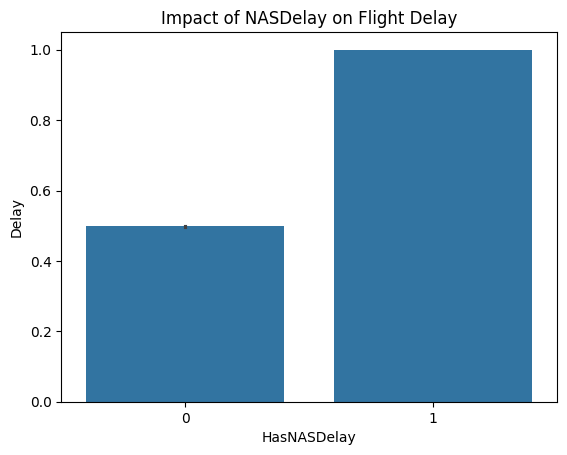

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasNASDelay', y='Delay', data=df_selected)
plt.title('Impact of NASDelay on Flight Delay')
plt.show()

In [34]:
# Create a new column if needed
df_selected['HasWeatherDelay'] = (df_selected['WeatherDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasWeatherDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasWeatherDelay,,
0,0.473049,0.526951
1,0.000000,1.000000


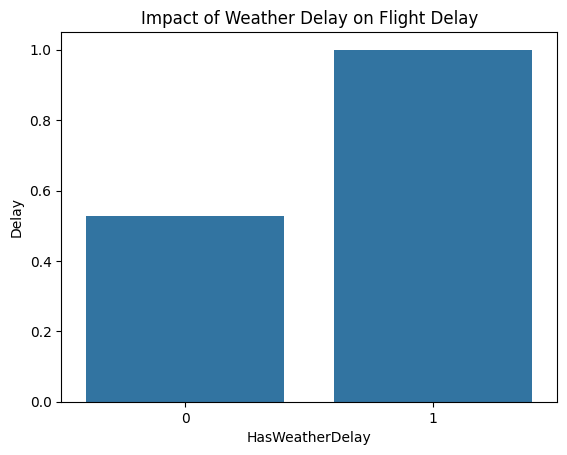

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasWeatherDelay', y='Delay', data=df_selected)
plt.title('Impact of Weather Delay on Flight Delay')
plt.show()

In [36]:
# Create a new column if needed
df_selected['HasCarrierDelay'] = (df_selected['CarrierDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasCarrierDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasCarrierDelay,,
0,0.49569,0.50431
1,0.00000,1.00000


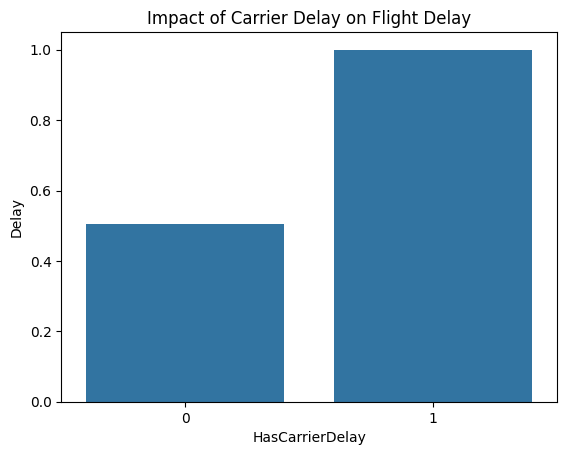

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasCarrierDelay', y='Delay', data=df_selected)
plt.title('Impact of Carrier Delay on Flight Delay')
plt.show()

In [37]:
# Create a new column if needed
df_selected['HasLateAircraftDelay'] = (df_selected['LateAircraftDelay'] > 0).astype(int)

# Now make a crosstab
pd.crosstab(df_selected['HasLateAircraftDelay'], df_selected['Delay'], normalize='index')

Delay,0,1
HasLateAircraftDelay,,
0,0.496707,0.503293
1,0.000000,1.000000


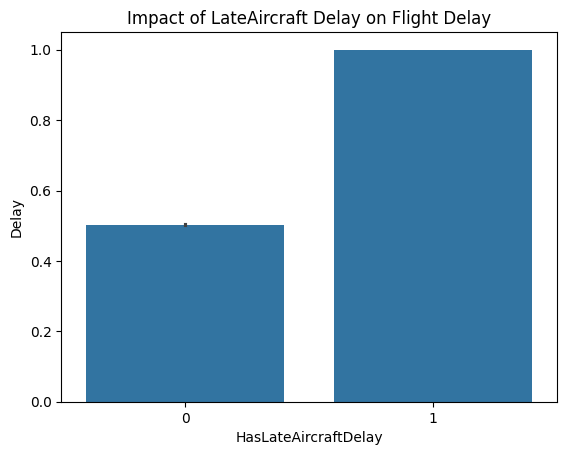

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='HasLateAircraftDelay', y='Delay', data=df_selected)
plt.title('Impact of LateAircraft Delay on Flight Delay')
plt.show()

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column 'DelayOccurred' based on whether the flight was delayed
df['DelayOccurred'] = ((df['DepDelay'] > 0) | (df['ArrDelay'] > 0)).astype(int)

# Check the first few rows to ensure it worked
df[['DepDelay', 'ArrDelay', 'DelayOccurred']].head()

,DepDelay,ArrDelay,DelayOccurred
0,19.0,23.0,1
1,-2.0,0.0,0
2,14.0,-3.0,1
3,0.0,-20.0,0
4,51.0,32.0,1


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

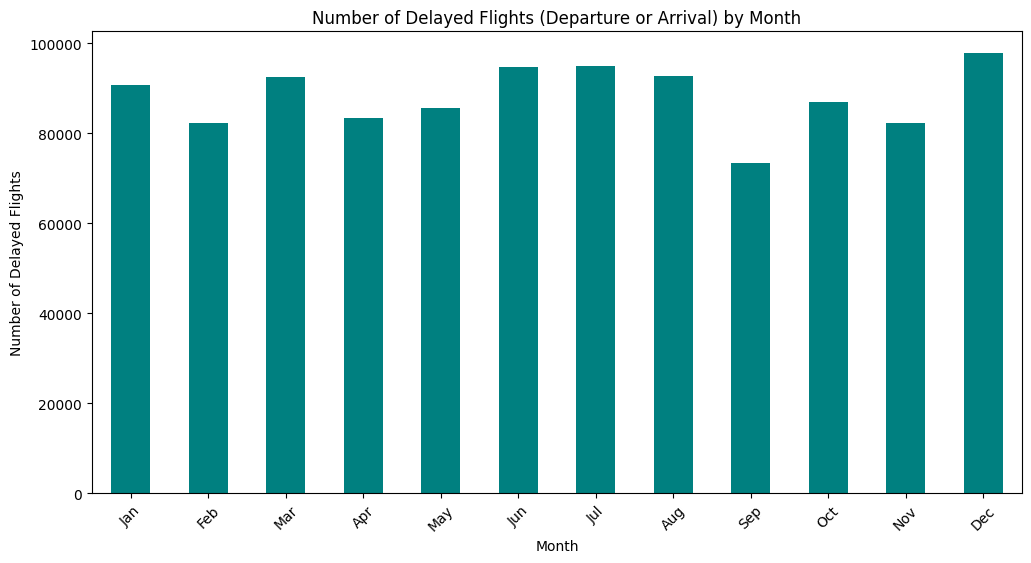

In [12]:
# Drop rows with NaN values in 'DepDelay', 'ArrDelay', and 'Month'
df = df.dropna(subset=['DepDelay', 'ArrDelay', 'Month'])

# Filter out rows where either departure delay or arrival delay is greater than 0
delayed_flights = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)]

# Calculate the number of delayed flights by month (either DepDelay or ArrDelay > 0)
monthly_delayed_flights = delayed_flights.groupby('Month').size()

# Plot the number of delayed flights by month
plt.figure(figsize=(12, 6))
monthly_delayed_flights.plot(kind='bar', color='teal')
plt.title('Number of Delayed Flights (Departure or Arrival) by Month')
plt.xlabel('Month')
plt.ylabel('Number of Delayed Flights')
plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()


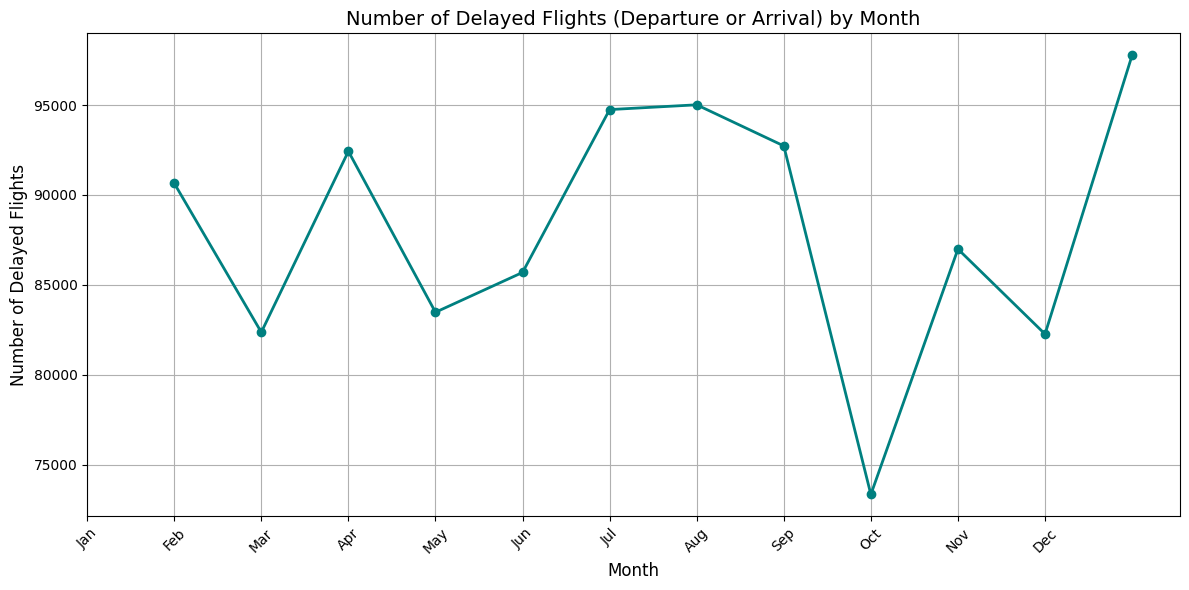

In [ ]:
import matplotlib.pyplot as plt

# Drop rows with NaN values in 'DepDelay', 'ArrDelay', and 'Month'
df = df.dropna(subset=['DepDelay', 'ArrDelay', 'Month'])

# Filter out rows where either departure delay or arrival delay is greater than 0
delayed_flights = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)]

# Calculate the number of delayed flights by month (either DepDelay or ArrDelay > 0)
monthly_delayed_flights = delayed_flights.groupby('Month').size()

# Plot the number of delayed flights by month using a line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_delayed_flights.index, monthly_delayed_flights.values, marker='o', color='teal', linewidth=2)

# Adding titles and labels
plt.title('Number of Delayed Flights (Departure or Arrival) by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)

# Customize the x-ticks to show month names
plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Show gridlines for better readability
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

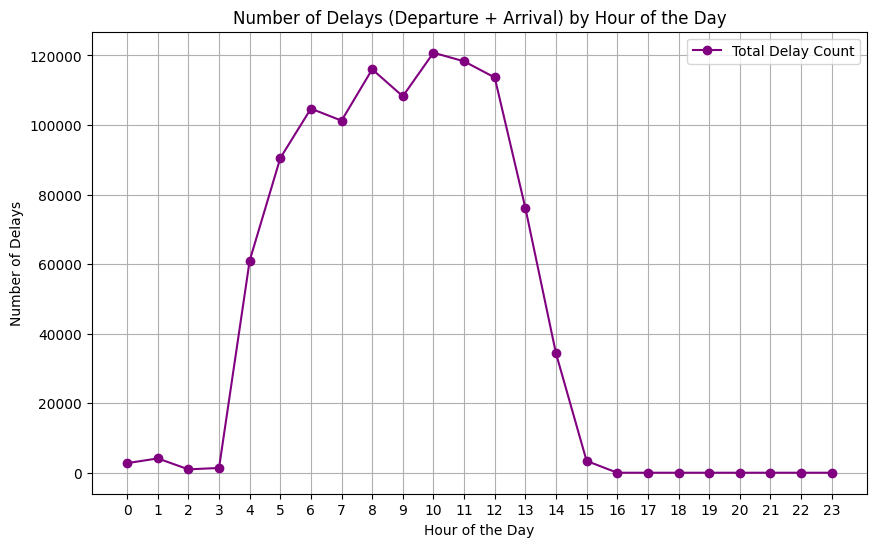

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert DepTime and ArrTime to hours, handle 24-hour clock properly
df['DepHour'] = (df['DepTime'] // 100) + (df['DepTime'] % 100) / 60.0
df['ArrHour'] = (df['ArrTime'] // 100) + (df['ArrTime'] % 100) / 60.0

# Round hours for better grouping, particularly if you're dealing with fractional hours
df['DepHour'] = df['DepHour'].round()
df['ArrHour'] = df['ArrHour'].round()

# Filter the dataset to include only rows with delays (either DepDelay or ArrDelay > 0)
df_delayed = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)].copy()  # Make a copy to avoid SettingWithCopyWarning

# Create the 'Delay' column (combined DepDelay and ArrDelay)
df_delayed['Delay'] = df_delayed['DepDelay'] + df_delayed['ArrDelay']

# Count the total number of delays by hour for both Departure and Arrival combined (ensure full range 0-23)
delay_count_by_hour = df_delayed.groupby('DepHour').size().reindex(range(24), fill_value=0)

# Plotting the Total Delay Counts (combined Departure and Arrival) by Hour of the Day
plt.figure(figsize=(10, 6))
plt.plot(delay_count_by_hour.index, delay_count_by_hour.values, marker='o', color='purple', label='Total Delay Count')
plt.title('Number of Delays (Departure + Arrival) by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Delays')
plt.grid(True)
plt.legend()
plt.xticks(range(24))  # Ensure the x-axis includes all hours (0-23)
plt.show()

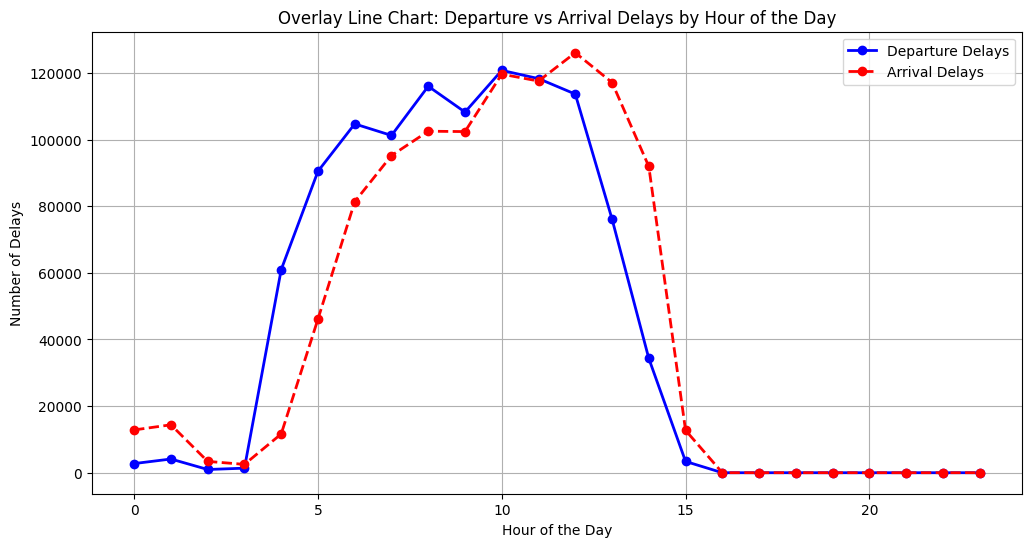

In [25]:
# Plotting Overlay Line Chart of Departure and Arrival Delays by Hour of the Day
plt.figure(figsize=(12, 6))

# Departure delay line
plt.plot(dep_delay_count_by_hour.index, dep_delay_count_by_hour.values, marker='o', color='blue', linestyle='-', linewidth=2, label='Departure Delays')

# Arrival delay line (dashed)
plt.plot(arr_delay_count_by_hour.index, arr_delay_count_by_hour.values, marker='o', color='red', linestyle='--', linewidth=2, label='Arrival Delays')

# Titles and labels
plt.title('Overlay Line Chart: Departure vs Arrival Delays by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Delays')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


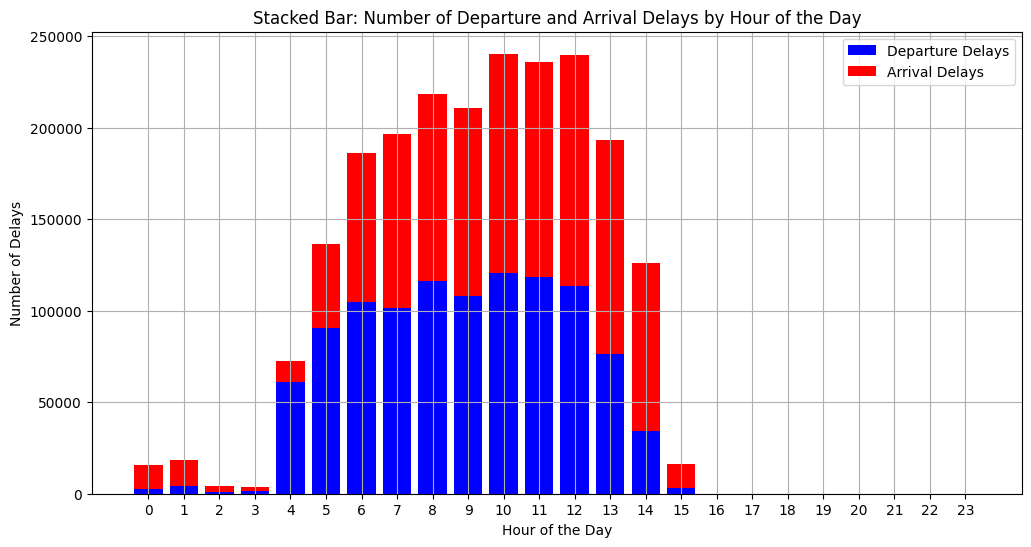

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert DepTime and ArrTime to hours, handle 24-hour clock properly
df['DepHour'] = (df['DepTime'] // 100) + (df['DepTime'] % 100) / 60.0
df['ArrHour'] = (df['ArrTime'] // 100) + (df['ArrTime'] % 100) / 60.0

# Round hours for better grouping, particularly if you're dealing with fractional hours
df['DepHour'] = df['DepHour'].round()
df['ArrHour'] = df['ArrHour'].round()

# Filter the dataset to include only rows with delays (either DepDelay or ArrDelay > 0)
df_delayed = df[(df['DepDelay'] > 0) | (df['ArrDelay'] > 0)]

# Count the number of delays by hour for Departure (ensure full range 0-23)
dep_delay_count_by_hour = df_delayed.groupby('DepHour').size().reindex(range(24), fill_value=0)

# Count the number of delays by hour for Arrival (ensure full range 0-23)
arr_delay_count_by_hour = df_delayed.groupby('ArrHour').size().reindex(range(24), fill_value=0)

# Plotting Stacked Bar Chart of Departure and Arrival Delays by Hour of the Day
plt.figure(figsize=(12, 6))

# Stacked bar chart
plt.bar(dep_delay_count_by_hour.index, dep_delay_count_by_hour.values, color='blue', label='Departure Delays')
plt.bar(arr_delay_count_by_hour.index, arr_delay_count_by_hour.values, bottom=dep_delay_count_by_hour.values, color='red', label='Arrival Delays')

# Titles and labels
plt.title('Stacked Bar: Number of Departure and Arrival Delays by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Delays')
plt.xticks(range(24))  # Ensure the x-axis includes all hours (0-23)
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("cleaned_flight_data.csv", encoding="ISO-8859-1", low_memory=False)

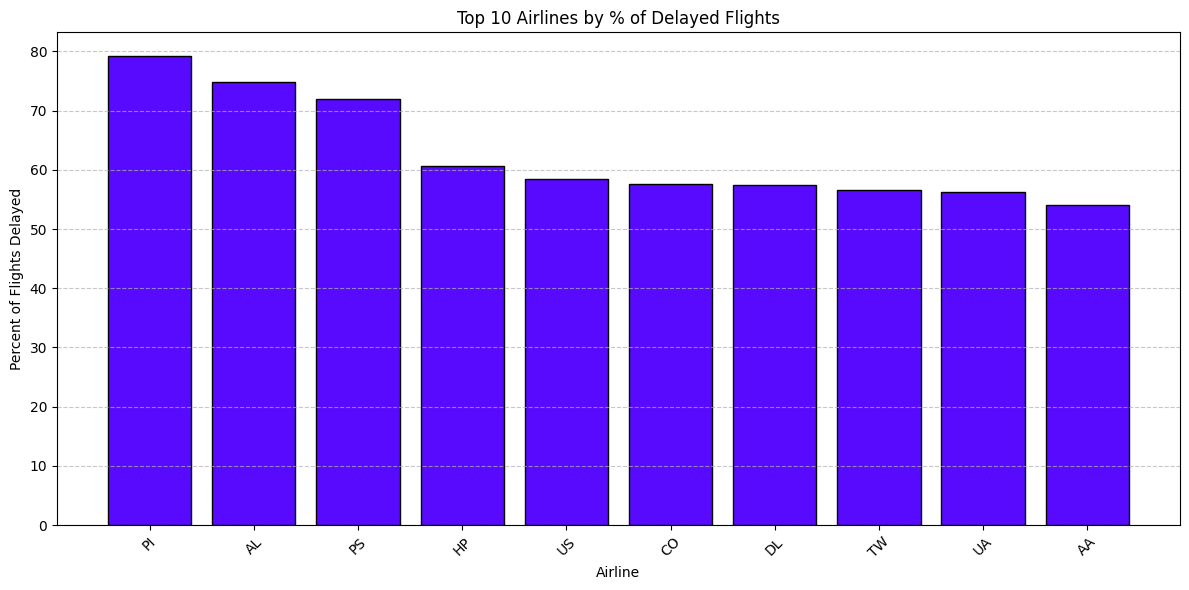

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Select the needed columns and make a copy to avoid SettingWithCopyWarning
data = df[['IATA_CODE_Reporting_Airline', 'DepDelay', 'ArrDelay', 'Flights']].copy()

# Step 2: Create the 'Delay' column
data.loc[:, 'Delay'] = ((data['DepDelay'] > 0) | (data['ArrDelay'] > 0)).astype(int)

# Step 3: Get total flights per airline
alldata = data[['IATA_CODE_Reporting_Airline', 'Flights']]
alldata = alldata.groupby('IATA_CODE_Reporting_Airline').sum().reset_index()
alldata.columns = ['Airline', 'Flights']

# Step 4: Get number of delayed flights per airline
delay_data = data[['IATA_CODE_Reporting_Airline', 'Delay']]
delay_data = delay_data.groupby('IATA_CODE_Reporting_Airline').sum().reset_index()
delay_data.columns = ['Airline', 'Delayed']

# Step 5: Merge total flights and delayed flights
ratio_data = pd.merge(alldata, delay_data, on='Airline', how='left')
ratio_data['Delayed'] = ratio_data['Delayed'].fillna(0)  # In case no delays for some airlines
ratio_data['Percent Delayed'] = (ratio_data['Delayed'] / ratio_data['Flights']) * 100

# Step 6: Sort by % delayed and take Top 10
ratio_data = ratio_data.sort_values('Percent Delayed', ascending=False).head(10)

# Step 7: Plot
plt.figure(figsize=(12, 6))
plt.bar(ratio_data['Airline'], ratio_data['Percent Delayed'], color='#580aff', edgecolor='black')
plt.title('Top 10 Airlines by % of Delayed Flights')
plt.xlabel('Airline')
plt.ylabel('Percent of Flights Delayed')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
# Step 1: Select the needed columns and make a copy to avoid SettingWithCopyWarning
df_selected = df[['DayOfWeek', 'DepDelay', 'ArrDelay', 'Flights']].copy()

# Check if the flight is on a weekend (Saturday=6, Sunday=7)
df_selected['IsWeekend'] = df_selected['DayOfWeek'].isin([6, 7]).astype(int)

df_selected.columns = df_selected.columns.str.strip()  # Remove leading/trailing spaces

# Check if either departure or arrival delay > 0 minutes
df_selected['Delay'] = ((df_selected['DepDelay'] > 0) | (df_selected['ArrDelay'] > 0)).astype(int)

# Calculate the correlation between IsWeekend and Delay
correlation = df_selected[['IsWeekend', 'Delay']].corr()

# Print the correlation matrix
print("Correlation between IsWeekend and Delay:")
print(correlation)

Correlation between IsWeekend and Delay:
           IsWeekend     Delay
IsWeekend   1.000000 -0.021793
Delay      -0.021793  1.000000


In [17]:
# Step 1: Select the needed columns and make a copy to avoid SettingWithCopyWarning
df_selected = df[['DayOfWeek', 'DepDelay', 'ArrDelay', 'Flights']].copy()

# Check if the flight is on a weekday (Monday = 1, Tuesday = 2, Wednesday = 3, Thursday = 4, Friday = 5)
df_selected['IsWeekday'] = df_selected['DayOfWeek'].isin([1, 2, 3, 4, 5]).astype(int)

df_selected.columns = df_selected.columns.str.strip()  # Remove leading/trailing spaces

# Check if either departure or arrival delay > 0 minutes
df_selected['Delay'] = ((df_selected['DepDelay'] > 0) | (df_selected['ArrDelay'] > 0)).astype(int)

# Calculate the correlation between IsWeekend and Delay
correlation = df_selected[['IsWeekday', 'Delay']].corr()

# Print the correlation matrix
print("Correlation between IsWeekday and Delay:")
print(correlation)

Correlation between IsWeekday and Delay:
           IsWeekday     Delay
IsWeekday   1.000000  0.021793
Delay       0.021793  1.000000


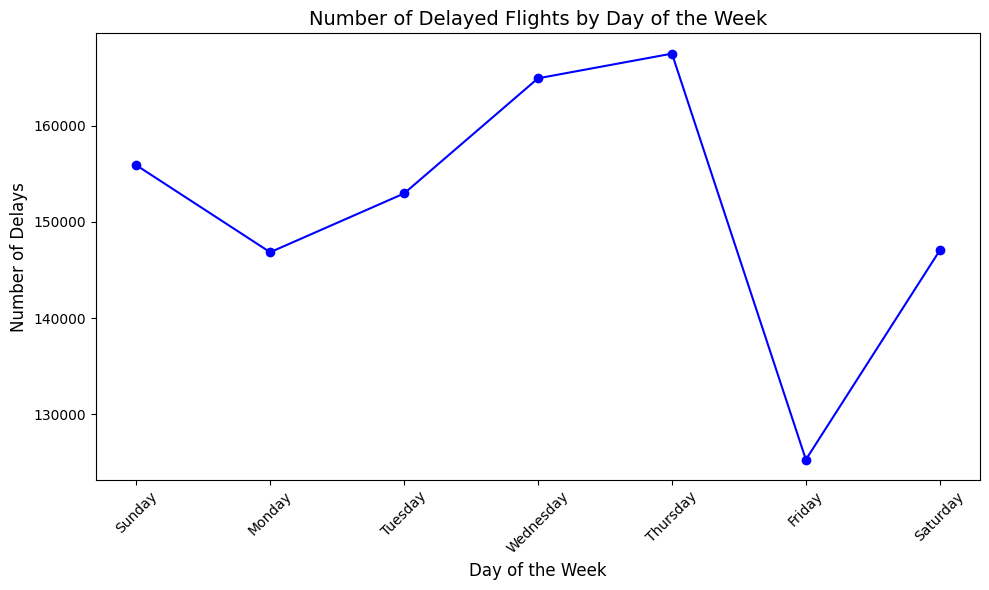

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame

# Step 1: Create the 'Delay' column
df['Delay'] = ((df['DepDelay'] > 0) | (df['ArrDelay'] > 0)).astype(int)

# Step 2: Group by DayOfWeek and sum the delays (1 means delayed)
delay_by_day = df.groupby('DayOfWeek')['Delay'].sum().reset_index()

# Step 3: Map DayOfWeek values to their respective names
day_map = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
           5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
delay_by_day['Day'] = delay_by_day['DayOfWeek'].map(day_map)

# Step 4: Sort the data by DayOfWeek for proper chronological order
delay_by_day = delay_by_day.sort_values('DayOfWeek', ignore_index=True)

# Step 5: Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(delay_by_day['Day'], delay_by_day['Delay'], marker='o', linestyle='-', color='b')

# Step 6: Add labels and title
plt.title('Number of Delayed Flights by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Step 7: Display the plot
plt.tight_layout()
plt.show()

Top tail numbers with the most delays:
Tail_Number
N963DL    263
N956DL    254
N904DE    252
N972DL    251
N912DE    250
N961DL    250
N944DL    250
N955DL    246
N951DL    245
N997DL    244
Name: count, dtype: int64


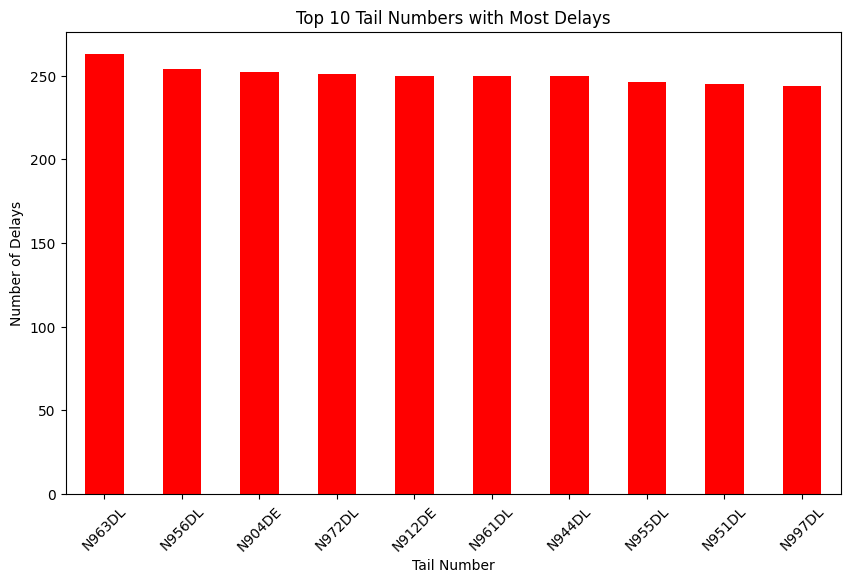

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your dataset into a DataFrame called df
# Make sure 'Delay' column is created (1 for delayed, 0 for on time)

# Check for delayed flights by TailNumber
tail_number_delays = df[df['Delay'] == 1]['Tail_Number'].value_counts()

# Display the tail numbers with the most delays
print("Top tail numbers with the most delays:")
print(tail_number_delays.head(10))  # Top 10 tail numbers with the most delays

# Plot the delays per TailNumber
plt.figure(figsize=(10, 6))
tail_number_delays.head(10).plot(kind='bar', color='red')
plt.title('Top 10 Tail Numbers with Most Delays')
plt.xlabel('Tail Number')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45)
plt.show()